In [13]:
import tensorflow as tf
import os
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Convolution2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
import pandas as pd
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import roc_auc_score
import requests

In [14]:
# config
test_p        = 0.1 # тестовая выборка 10%
val_p         = 0.2 # валидационная выборка 20%
target_size   = (224, 224) # ресайз всех картинок в квадратные
batch_size    = 32
learning_rate = 1e-4

### Импорт и организация датасета

In [3]:
labels = pd.read_csv('images_labelling.csv')
labels.head()

,boxid,label,class_
0,40498,1,B48
1,24303,1,B48
2,48328,1,B48
3,13981,1,B48
4,19874,1,B48


In [4]:
df = labels.drop_duplicates(subset=['label'])

In [19]:
df[['label','class_']][df.label==1].label.values, df[['label','class_']][df.label==1].class_.values

(array([1], dtype=int64), array(['B48'], dtype=object))

In [4]:
# create classes folders
for i in range(25):
    os.mkdir(os.path.join('images', str(i)))

# split files to classes directories
for fname in os.listdir('images'):
    if ".png" in fname:
        box_id = int(fname.split('.')[0])
        label = str(labels[labels.boxid==box_id].label.values[0])
        Path(os.path.join('images',fname)).rename(os.path.join('images',label,fname))

# create train-test-val folder structure
for fld in ['train', 'val', 'test']:
    os.mkdir(os.path.join('images', fld))
    for i in range(25):
        os.mkdir(os.path.join('images', fld, str(i)))
        
# shuffle and relocate files
for i in range(25):
    files = os.listdir(os.path.join('images',str(i)))
    random.shuffle(files)
    n_files = len(os.listdir(os.path.join('images',str(i))))
    n_test = int(n_files*test_p)
    n_val = int(n_files*val_p)
    test_files = files[:n_test]
    val_files = files[n_test:n_test+n_val]
    train_files = files[n_test+n_val:]
    for fname in test_files: Path(os.path.join('images',str(i), fname)).rename(os.path.join('images','test', str(i), fname))
    for fname in train_files: Path(os.path.join('images',str(i), fname)).rename(os.path.join('images','train', str(i), fname))
    for fname in val_files: Path(os.path.join('images',str(i), fname)).rename(os.path.join('images','val', str(i), fname))
    os.rmdir(os.path.join('images', str(i)))

### Подготовка к обучению

In [15]:
# batch generators

train_datagen = ImageDataGenerator(
        rescale=1./255,
#         horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'images/val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        'images/test',
        target_size=target_size,
        batch_size=1,
        class_mode='categorical')

Found 2625 images belonging to 25 classes.
Found 750 images belonging to 25 classes.
Found 375 images belonging to 25 classes.


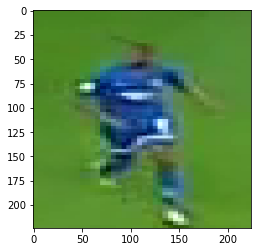

In [16]:
# check data from generator
validation_generator[1][1][0,...]
plt.imshow(validation_generator[1][0][0,...]);

In [17]:
# define simple model

model = Sequential()
input_shape = (target_size[0],target_size[0],3)
model.add(Convolution2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['AUC'])
# model.summary()

### Обучение

In [26]:
n_epochs   = 100
verbose    = 1

checkpoint_filepath = os.path.join('checkpoints','checkpoint')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=verbose)
lr_reduce  = ReduceLROnPlateau(monitor='val_AUC', min_lr=0, cooldown=2, factor=0.1, patience=5, verbose=verbose, mode='max')
model_checkpoint_callback =ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='AUC',
    mode='max',
    save_best_only=True,
    save_freq='epoch')

history = model.fit_generator(generator=train_generator, validation_data=validation_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce, model_checkpoint_callback],#tensorboard_callback],#, m_save],                              
                             verbose=verbose, workers=1, use_multiprocessing=False)

Epoch 1/100
83/83 [==============================] - 14s 164ms/step - loss: 3.1881 - AUC: 0.5618 - val_loss: 3.1108 - val_AUC: 0.6884
Epoch 2/100
83/83 [==============================] - 12s 143ms/step - loss: 3.0822 - AUC: 0.6510 - val_loss: 2.9807 - val_AUC: 0.7229
Epoch 3/100
83/83 [==============================] - 12s 142ms/step - loss: 2.9890 - AUC: 0.6809 - val_loss: 2.8589 - val_AUC: 0.7639
Epoch 4/100
83/83 [==============================] - 12s 143ms/step - loss: 2.9247 - AUC: 0.7074 - val_loss: 2.7898 - val_AUC: 0.7773
Epoch 5/100
83/83 [==============================] - 12s 144ms/step - loss: 2.8793 - AUC: 0.7215 - val_loss: 2.7086 - val_AUC: 0.7907
Epoch 6/100
83/83 [==============================] - 12s 144ms/step - loss: 2.8517 - AUC: 0.7298 - val_loss: 2.6716 - val_AUC: 0.8015
Epoch 7/100
83/83 [==============================] - 12s 144ms/step - loss: 2.8013 - AUC: 0.7426 - val_loss: 2.6445 - val_AUC: 0.8064
Epoch 8/100
83/83 [==============================] - 12s 144ms

83/83 [==============================] - 11s 138ms/step - loss: 1.6233 - AUC: 0.9309 - val_loss: 1.2367 - val_AUC: 0.9601
Epoch 61/100
83/83 [==============================] - 11s 137ms/step - loss: 1.6236 - AUC: 0.9307 - val_loss: 1.2259 - val_AUC: 0.9616
Epoch 62/100
83/83 [==============================] - 12s 149ms/step - loss: 1.6054 - AUC: 0.9314 - val_loss: 1.2212 - val_AUC: 0.9605
Epoch 63/100
83/83 [==============================] - 12s 144ms/step - loss: 1.5999 - AUC: 0.9325 - val_loss: 1.2162 - val_AUC: 0.9618
Epoch 64/100
83/83 [==============================] - 11s 137ms/step - loss: 1.5934 - AUC: 0.9301 - val_loss: 1.2262 - val_AUC: 0.9616
Epoch 65/100
83/83 [==============================] - 11s 137ms/step - loss: 1.6113 - AUC: 0.9316 - val_loss: 1.2195 - val_AUC: 0.9613
Epoch 66/100
83/83 [==============================] - 12s 149ms/step - loss: 1.6066 - AUC: 0.9325 - val_loss: 1.2104 - val_AUC: 0.9612
Epoch 67/100
83/83 [==============================] - 11s 136ms/step

In [18]:
model.load_weights(os.path.join('checkpoints', 'checkpoint'))

In [40]:
# check metric on test data

y_true = np.zeros((len(test_generator),25))
y_pred = np.zeros((len(test_generator),25))

for i in range(len(test_generator)):
    res = model.predict(test_generator[i])
    y_pred[i,...] = res[0]
    y_true[i,...] = test_generator[i][1][0]
roc_auc_score(y_true,y_pred)

0.9590962962962963

### Предсказание

In [4]:
class_ = '17'
fname = '24022.png'

labels = pd.read_csv('images_labelling.csv')
labels.head()

f = {'file': open(os.path.join('images', 'test', class_, fname), 'rb')}
gt_label = labels[labels.boxid==int(fname.split('.')[0])].label.values[0]
r = requests.post('http://localhost:5000/predict', files=f)
print('%s label: gt=%s, pred=%s' % (fname, str(gt_label), str(r.json()['label'])))

24022.png label: gt=17, pred=5
